## Quantifying and removing Arc drift
8 July 2019

This notebook presents a  metric that could potentially be used to removed objects badly affected by arc drift.

The metric, referred to as "spike", is calculated as:

$log10(\frac{Spike \ frequency \ power}{Fit\ frequency\ power})$

Where Spike frequency power is the computed Lomb-Scargle power at 4.6296296296296294e-05 Hz (which corresponds to 1.5707963267948966 days)--this frequency was determined through trial and error. The Fit frequency power refers to the power derived from a linear fit below the noise floor at the frequency corresponding to 1.5 days. The spike value will therefore be large if there is a spike in power at the given frequency, or if the power spectrum below the 5 day noise floor is too steep.

**Note:** The light curves used in this notebook are raw light curves, read in from hdf5 files that were created using code from [this repository](https://github.com/Rodot-/CARMA).

In [2]:
from analysis import *
import h5py

### Campaign 8

In [7]:
dfc8 = pd.read_csv("object_keys/K2Campaign8_fromhdf5_summary.csv")

# looking for relatively flat objects 
mask = np.abs(np.array(dfc8['PSD_m_above_noise']))<0.5
short_df = dfc8[mask].sample(10)

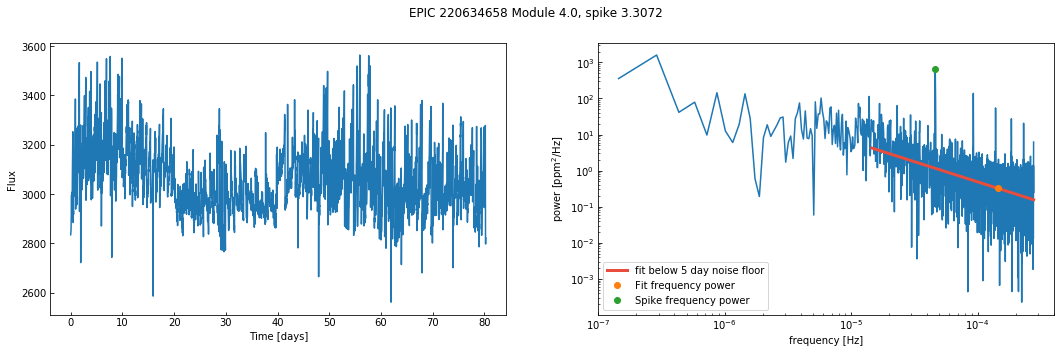

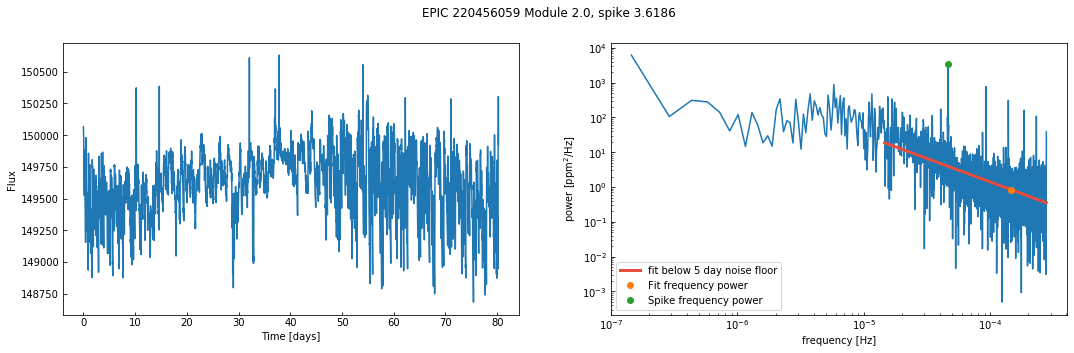

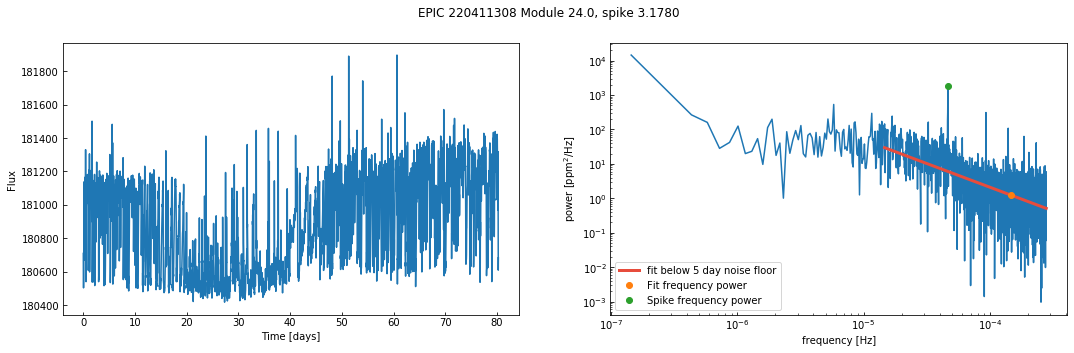

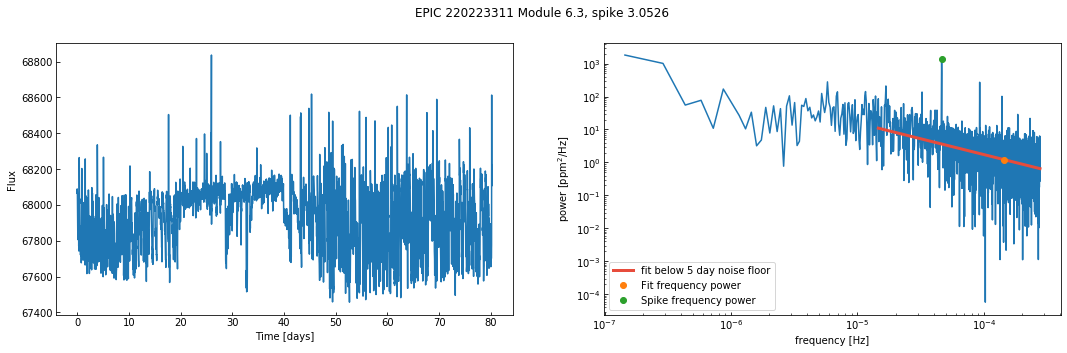

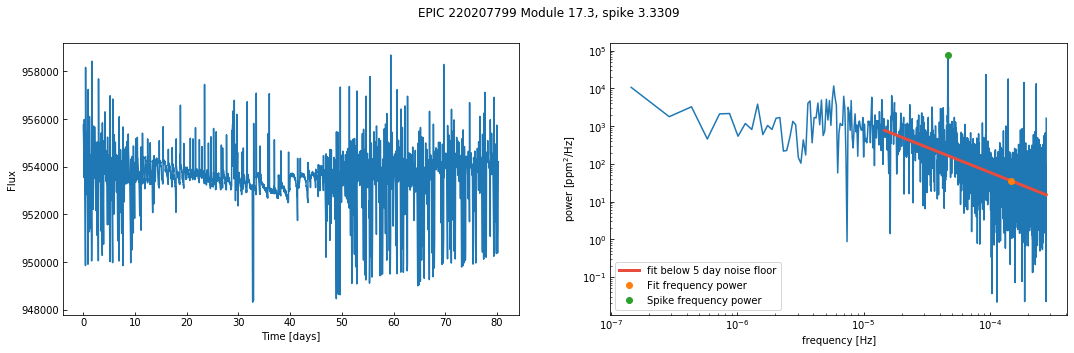

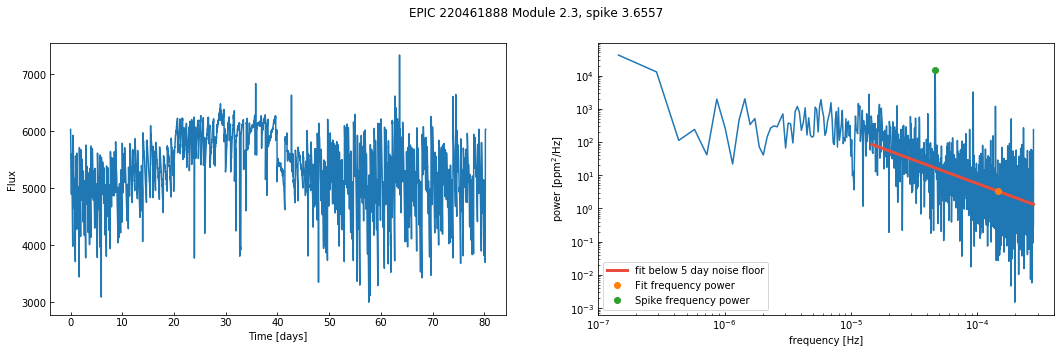

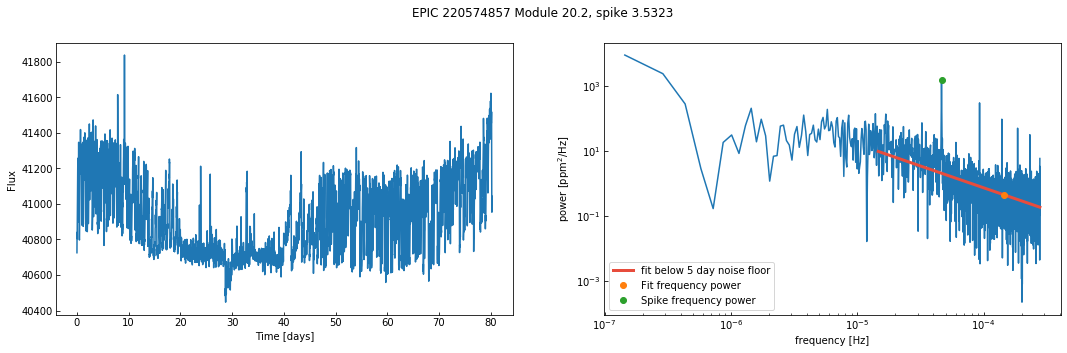

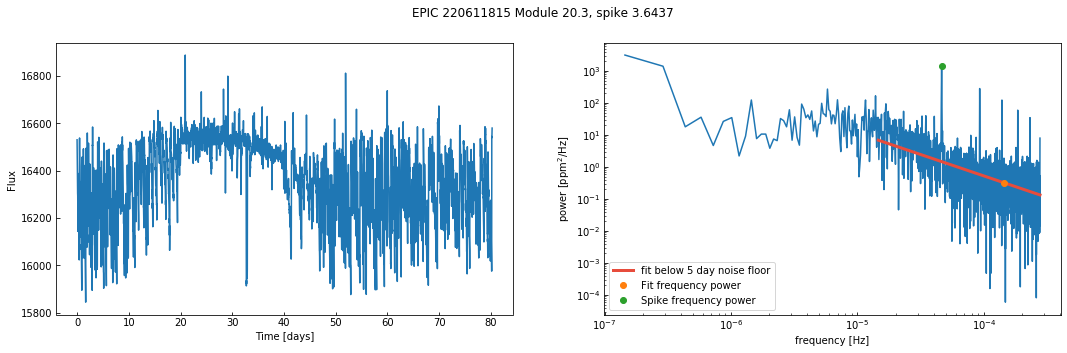

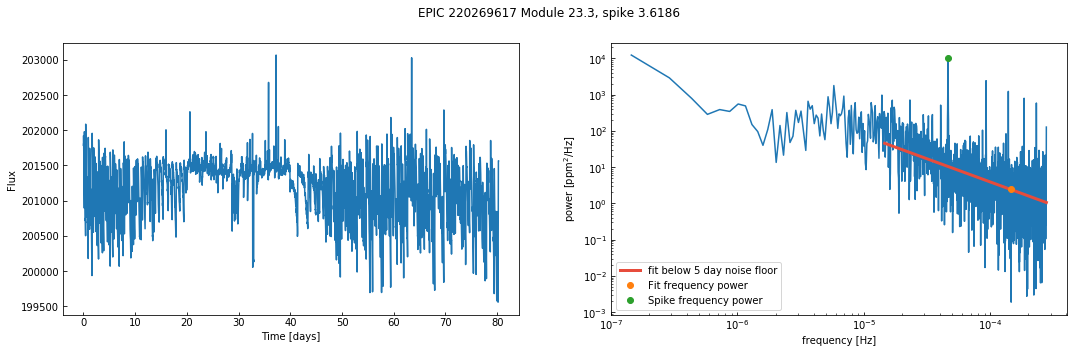

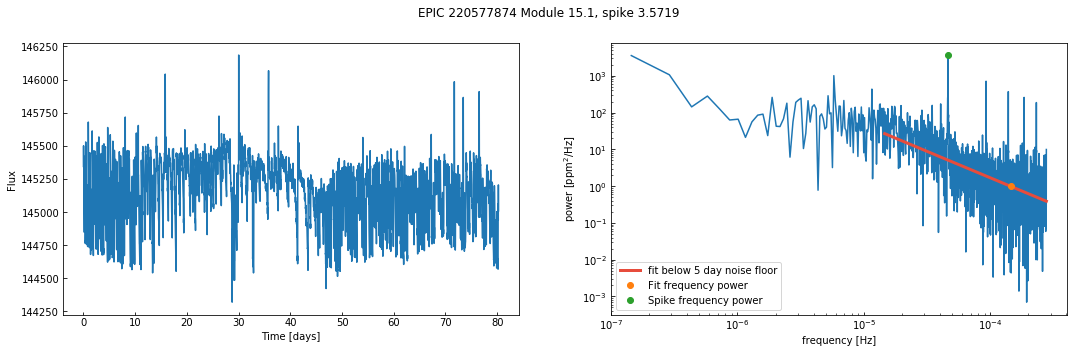

In [8]:
campaign=8
cadences = 3853#3853 for C8
time = np.arange(cadences)/48.0# time in days since start of campaign

hdf5_file = "./K2C%s_target_pixels.hdf5"%campaign
with h5py.File(hdf5_file, 'r') as f:
    for i in range(len(short_df)):
        epic = int(np.array(short_df['EPIC'])[i])
        mod = int(np.array(short_df['module'])[i])
        submod = int(np.array(short_df['submodule'])[i])
        gini = np.array(short_df['gini'])[i]
        
        
        d = np.array(f['%s/%s/%s/%s'%(campaign,mod,submod,epic)]['data'])
        lc_hdf5 = np.nansum(np.nansum(d, axis=1), axis=1)
        # handle spurious cadences
        lc = lk.LightCurve(time, flux=lc_hdf5)
        _, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
        lc_raw = lc.flux

        # interpolate
        cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement
        interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
        # replace spurious cadence values with the interpolated values
        lc_raw[spurious_cad] = interped_vals
        
        # calculate the PSD (looking for spikes at )        
        freq_raw,power_raw = LS_PSD(time*86400,lc_raw,f=k2_freq)
        
        
        # noise floor are freqencies > X days, convert to Hz
        noise_floor_days = 5
        noise_floor_mask = freq_raw>(2*np.pi/(noise_floor_days*86400))
        m_noise, b_noise = np.polyfit(np.log10(freq_raw)[noise_floor_mask], np.log10(power_raw)[noise_floor_mask], 1)
        
        freq_six_hour = (2*np.pi/(0.5*86400)) # frequency for 2*6 hour thurster fire 2x0.25days
        
        # lomb scargle for single frequency
        # Compute the LS based power spectrum estimates
        model = LombScargle(time*86400, lc_raw)
        power_six_hour = model.power(freq_six_hour, method="fast", normalization="psd")
        power_six_hour /= len(time)

        #freq_temp = (2*np.pi/(1.5*86400)) 
        freq_temp = k2_freq[320]
        power_temp = model.power(freq_temp, method="fast", normalization="psd")
        power_temp /= len(time)
        
        
        spike = np.log10(power_temp/(10**(np.log10(freq_six_hour)*m_noise+b_noise))) # linear fit
        
        fig, ax = plt.subplots(1,2, figsize=(18,5))
        ax[0].plot(time, lc_raw)
        ax[0].set_xlabel("Time [days]")
        ax[0].set_ylabel("Flux")
        
        
        ax[1].plot(freq_raw, power_raw)
        ax[1].plot(freq_raw[noise_floor_mask], 10**(np.log10(freq_raw[noise_floor_mask])*m_noise+b_noise), 
             label="fit below 5 day noise floor"%m_noise, linewidth=3, alpha = 1, color='#e74c3c')
        ax[1].plot(freq_six_hour, 10**(np.log10(freq_six_hour)*m_noise+b_noise), 'o', label="Fit frequency power")
        ax[1].plot(freq_temp, power_temp, 'o', label="Spike frequency power")
        
        ax[1].set_xlabel("frequency [Hz]")
        ax[1].set_ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].legend()
        fig.suptitle("EPIC %s Module %s.%s, spike %.4f"%(epic,mod,submod, spike))

Let's implement a threshold (spike > 1.0), above which we consider objects as bad.

I went back in time and calculated spike values for all the objects, and saved them in the same csv file.

In [14]:
mask = np.logical_and(np.abs(np.array(dfc8['PSD_m_above_noise']))<0.7, np.array(dfc8['spike'])<1.0)
temp_df = dfc8[mask].sample(10)

In [15]:
print("%s Objects"%mask.sum())
temp_df

51 Objects


,EPIC,magnitude,module,submodule,gini,spike,PSD_m_above_noise,PSD_m_below_noise
17932,220413076.0,19.084,24.0,0.0,0.318721,-0.344453,-0.315176,-0.171149
1912,220271165.0,14.285,11.0,1.0,0.840169,0.845725,-0.274598,-0.639363
1537,220236119.0,17.606,11.0,0.0,0.496795,0.995401,-0.374854,-0.955188
5072,220401652.0,18.982,13.0,3.0,0.359726,0.675641,-0.497731,-0.090565
18115,220444485.0,9.155,24.0,0.0,0.861426,0.475391,-0.630146,-1.441461
5021,220392853.0,14.823,13.0,3.0,0.763247,0.014637,-0.426170,-0.811432
22323,220569769.0,6.912,9.0,1.0,0.921865,0.553801,0.136924,-0.837215
3593,220262484.0,17.288,12.0,3.0,0.680027,0.945709,-0.364397,-0.721202
10665,220398397.0,13.685,18.0,0.0,0.865274,0.617400,-0.571509,-0.927643
4441,220490186.0,14.793,13.0,1.0,0.826878,0.916763,-0.673507,-0.554933


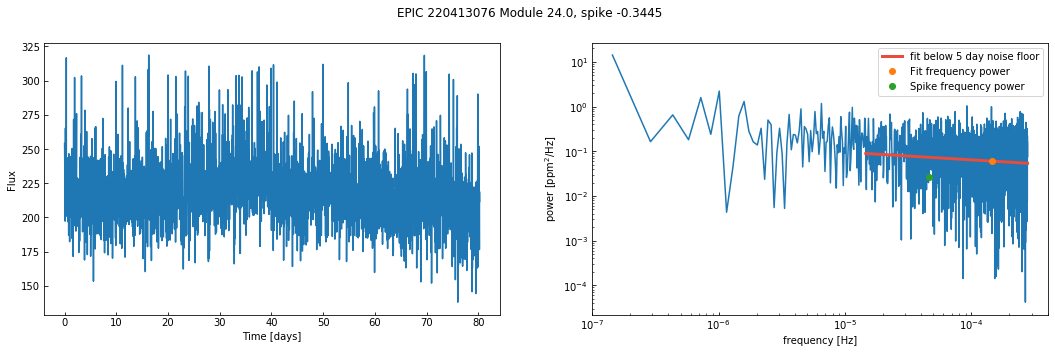

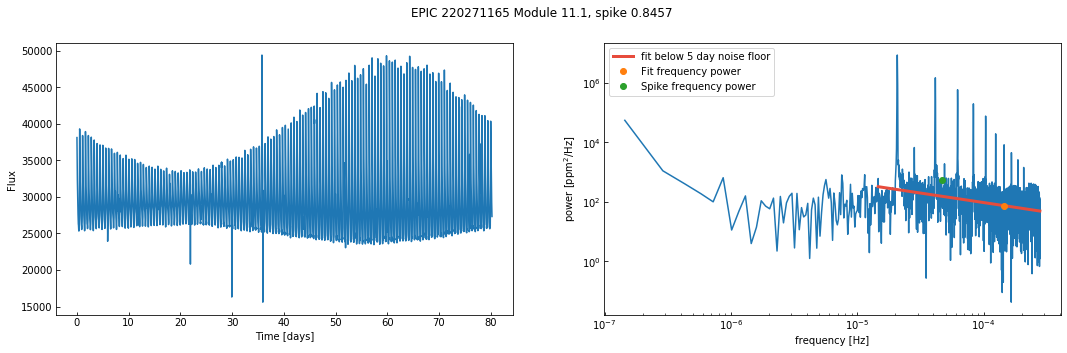

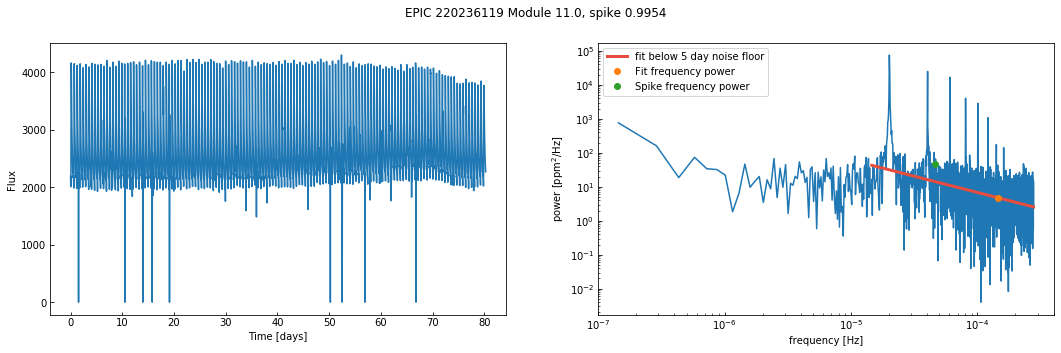

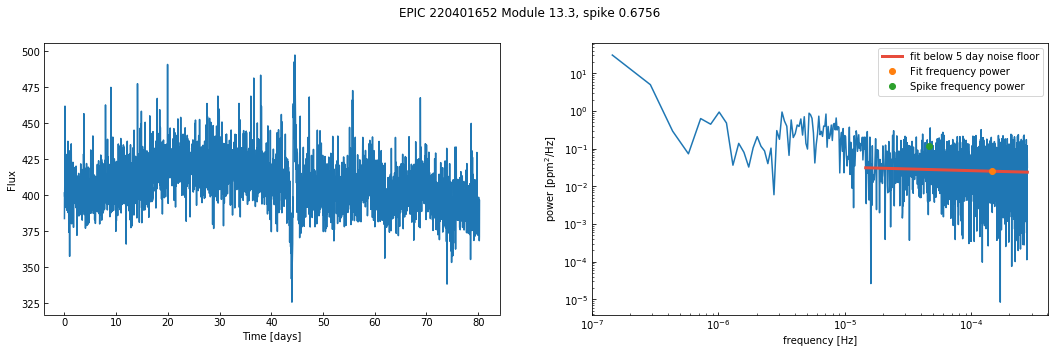

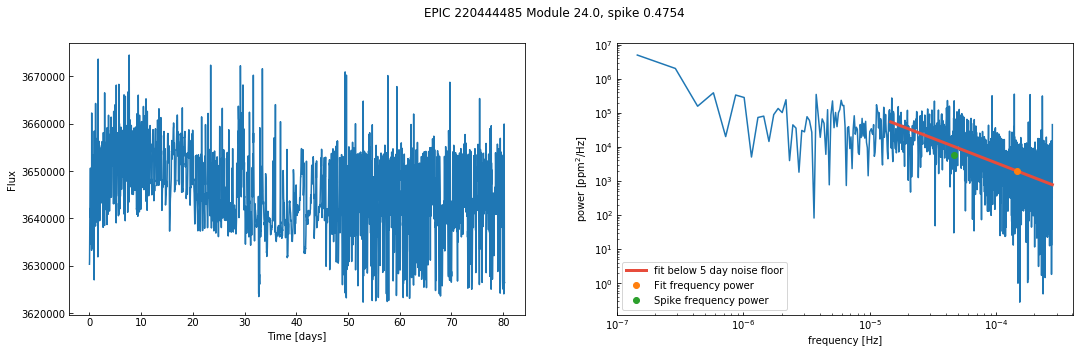

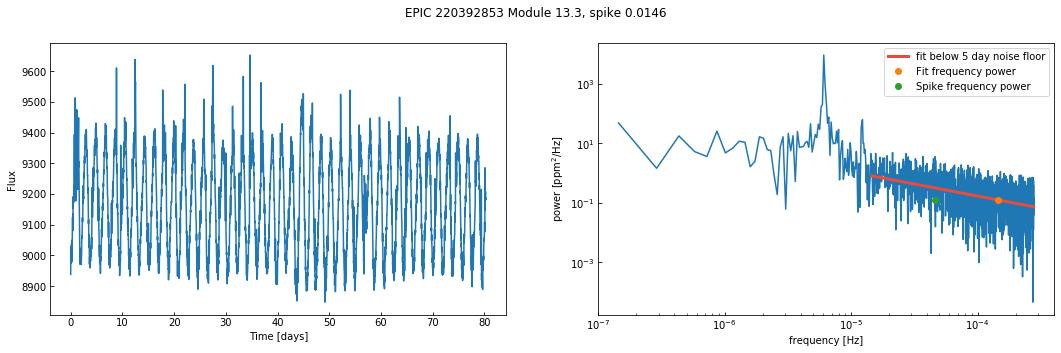

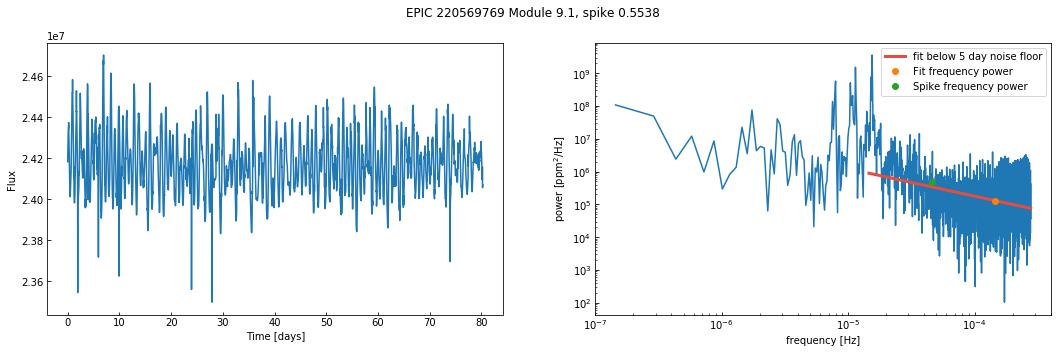

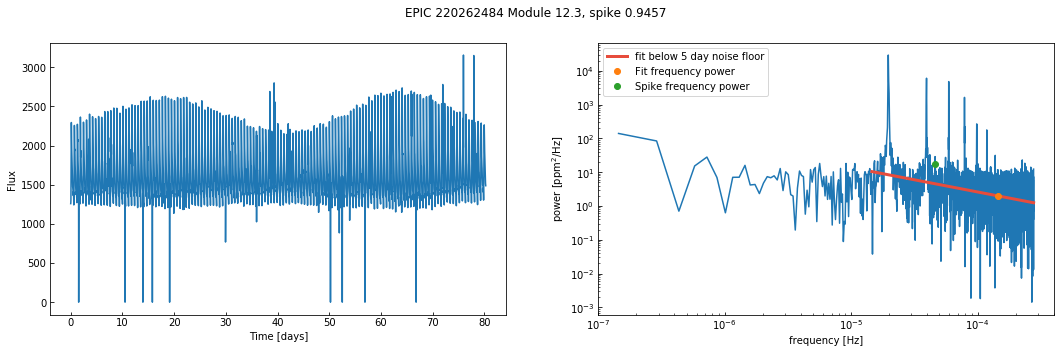

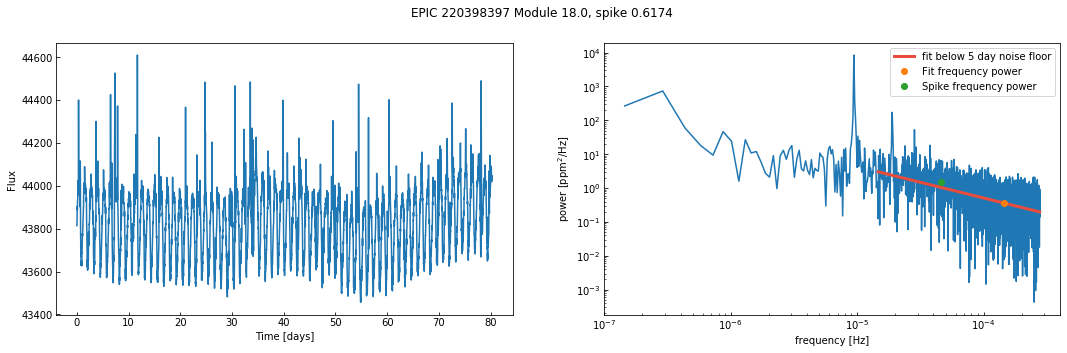

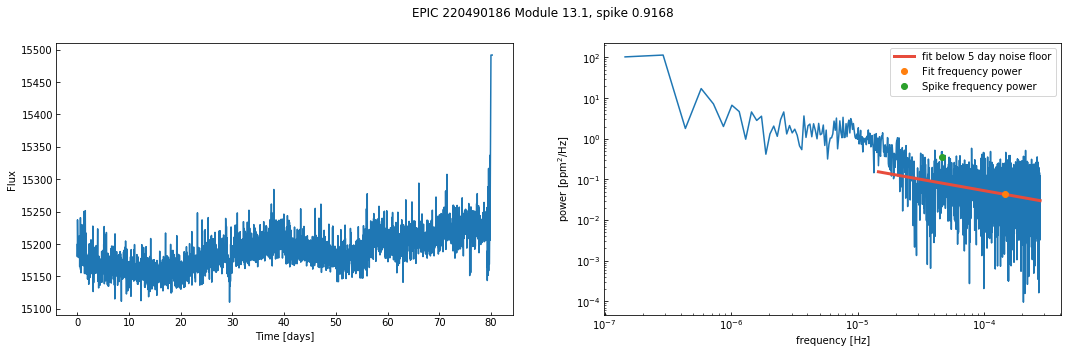

In [16]:
campaign=8
cadences = 3853#3853 for C8
time = np.arange(cadences)/48.0# time in days since start of campaign

hdf5_file = "./K2C%s_target_pixels.hdf5"%campaign
with h5py.File(hdf5_file, 'r') as f:
    for i in range(len(temp_df)):
        epic = int(np.array(temp_df['EPIC'])[i])
        mod = int(np.array(temp_df['module'])[i])
        submod = int(np.array(temp_df['submodule'])[i])
        gini = np.array(temp_df['gini'])[i]
        
        
        d = np.array(f['%s/%s/%s/%s'%(campaign,mod,submod,epic)]['data'])
        lc_hdf5 = np.nansum(np.nansum(d, axis=1), axis=1)
        # handle spurious cadences
        lc = lk.LightCurve(time, flux=lc_hdf5)
        _, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
        lc_raw = lc.flux

        # interpolate
        cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement
        interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
        # replace spurious cadence values with the interpolated values
        lc_raw[spurious_cad] = interped_vals
        
        # calculate the PSD (looking for spikes at )        
        freq_raw,power_raw = LS_PSD(time*86400,lc_raw,f=k2_freq)
        
        
        # noise floor are freqencies > X days, convert to Hz
        noise_floor_days = 5
        noise_floor_mask = freq_raw>(2*np.pi/(noise_floor_days*86400))
        m_noise, b_noise = np.polyfit(np.log10(freq_raw)[noise_floor_mask], np.log10(power_raw)[noise_floor_mask], 1)
        
        freq_six_hour = (2*np.pi/(0.5*86400)) # frequency for 4*6 hour thurster fire
        
        # lomb scargle for single frequency
        # Compute the LS based power spectrum estimates
        model = LombScargle(time*86400, lc_raw)
        power_six_hour = model.power(freq_six_hour, method="fast", normalization="psd")
        power_six_hour /= len(time)

        #freq_temp = (2*np.pi/(0.375*86400)) #0.25*1.5
        freq_temp = k2_freq[320]
        power_temp = model.power(freq_temp, method="fast", normalization="psd")
        power_temp /= len(time)
        
        
        spike = np.log10(power_temp/(10**(np.log10(freq_six_hour)*m_noise+b_noise)))
        
        fig, ax = plt.subplots(1,2, figsize=(18,5))
        ax[0].plot(time, lc_raw)
        ax[0].set_xlabel("Time [days]")
        ax[0].set_ylabel("Flux")
        
        
        ax[1].plot(freq_raw, power_raw)
        ax[1].plot(freq_raw[noise_floor_mask], 10**(np.log10(freq_raw[noise_floor_mask])*m_noise+b_noise), 
             label="fit below 5 day noise floor"%m_noise, linewidth=3, alpha = 1, color='#e74c3c')
        ax[1].plot(freq_six_hour, 10**(np.log10(freq_six_hour)*m_noise+b_noise), 'o', label="Fit frequency power")
        ax[1].plot(freq_temp, power_temp, 'o', label="Spike frequency power")
        
        ax[1].set_xlabel("frequency [Hz]")
        ax[1].set_ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].legend()
        fig.suptitle("EPIC %s Module %s.%s, spike %.4f"%(epic,mod,submod, spike))
        
        #fig.savefig("./submit/c8_control/EPIC_%s.png"%(epic))
        #plt.close()

These are the types of objects we're looking for to use as control objects.

---
### Campaign 16

Let's implement the same thing for campaign 16

In [8]:
dfc16 = pd.read_csv("object_keys/K2Campaign16_fromhdf5_summary.csv")

In [9]:
mask = np.logical_and(np.abs(np.array(dfc16['PSD_m_above_noise']))<0.7, np.array(dfc16['spike'])<1.0)
temp_df = dfc16[mask].sample(10)

In [10]:
print("%s Objects"%mask.sum())
temp_df

1240 Objects


,EPIC,magnitude,module,submodule,gini,spike,PSD_m_above_noise,PSD_m_below_noise
5706,200195313.0,-1.000,13.0,1.0,0.118733,0.233157,-0.292959,-0.599614
27833,200198531.0,-1.000,24.0,2.0,0.023247,-0.242026,0.094011,-1.880845
17221,200195737.0,-1.000,19.0,1.0,0.074043,0.574827,-0.686001,-0.137575
28261,251296062.0,18.204,24.0,2.0,0.068401,0.714908,-0.183185,-1.799086
18240,200200802.0,-1.000,19.0,2.0,0.071354,0.216231,-0.415111,-0.885265
19967,200199704.0,-1.000,2.0,1.0,0.158464,0.976933,-0.254793,-1.999334
28205,251294390.0,17.516,24.0,2.0,0.133105,0.728409,-0.303723,-0.848944
28599,251283416.0,16.872,24.0,3.0,0.552388,0.742463,-0.651618,-0.601855
9154,211492541.0,12.789,15.0,0.0,0.936244,0.660471,-0.362821,-0.858167
26970,200197489.0,-1.000,24.0,1.0,0.075474,0.637185,0.149271,-1.549954


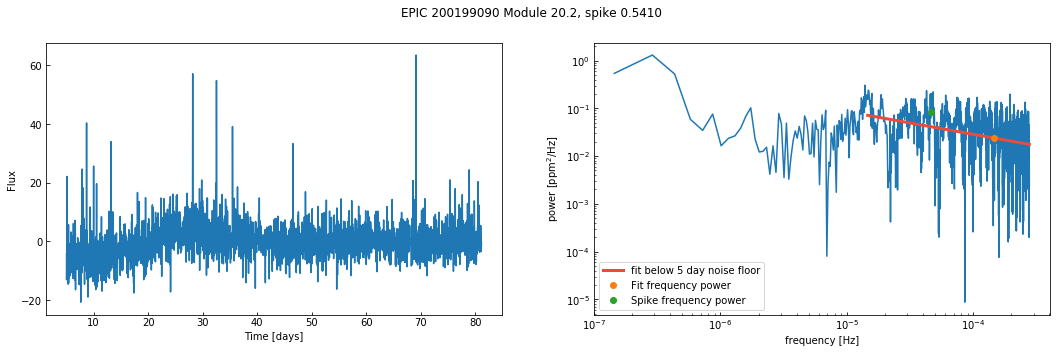

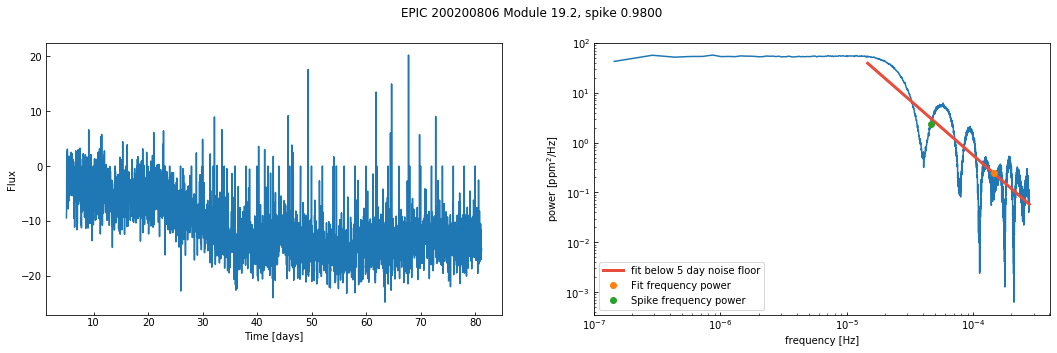

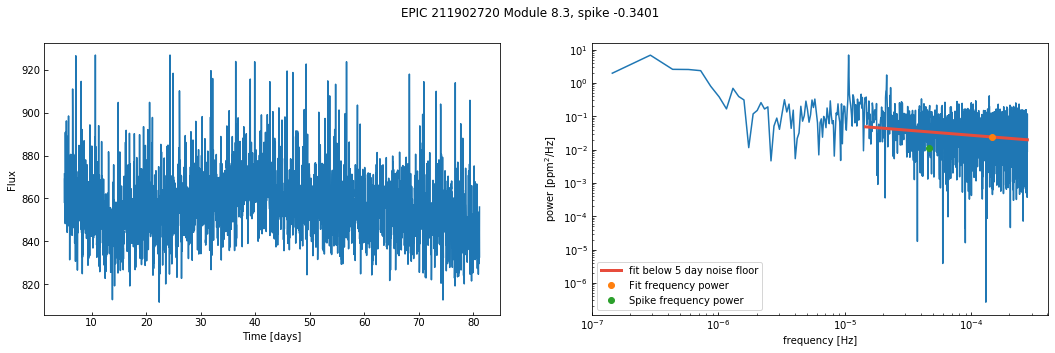

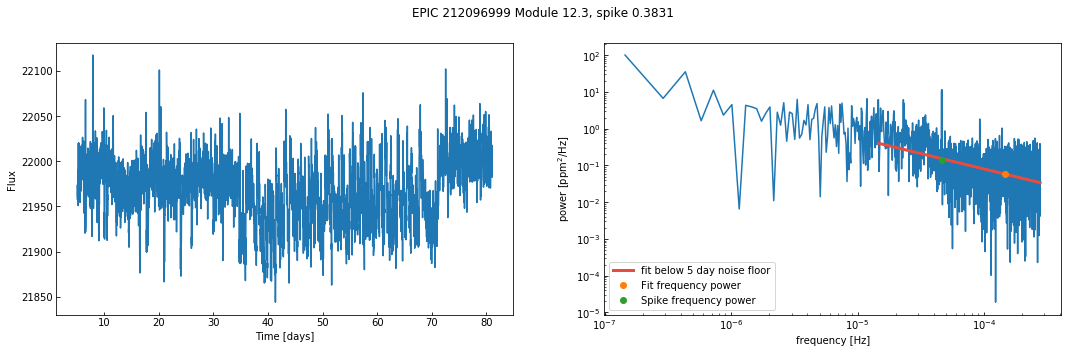

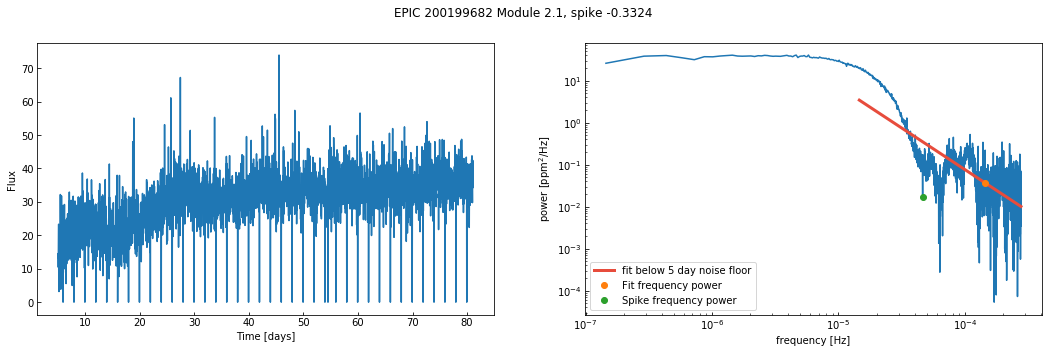

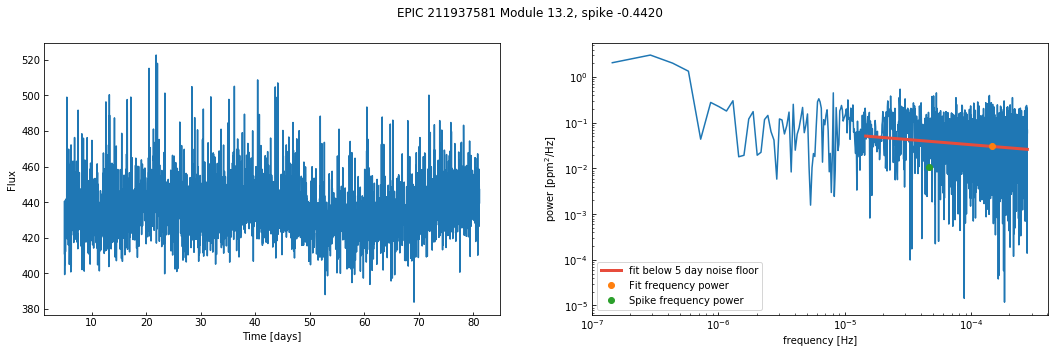

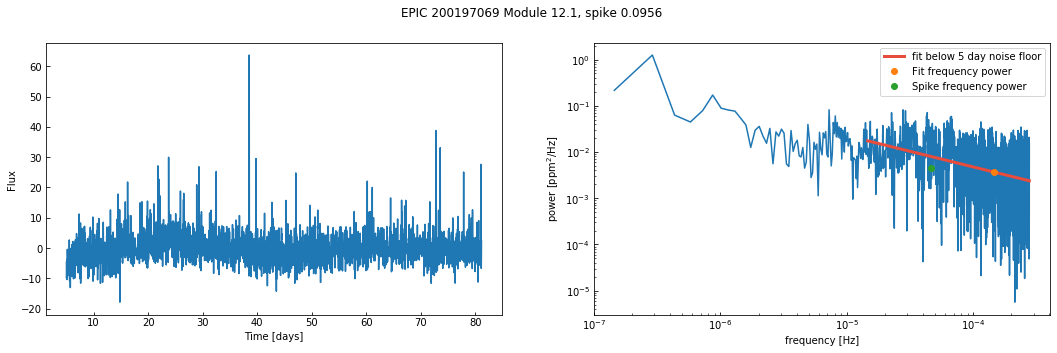

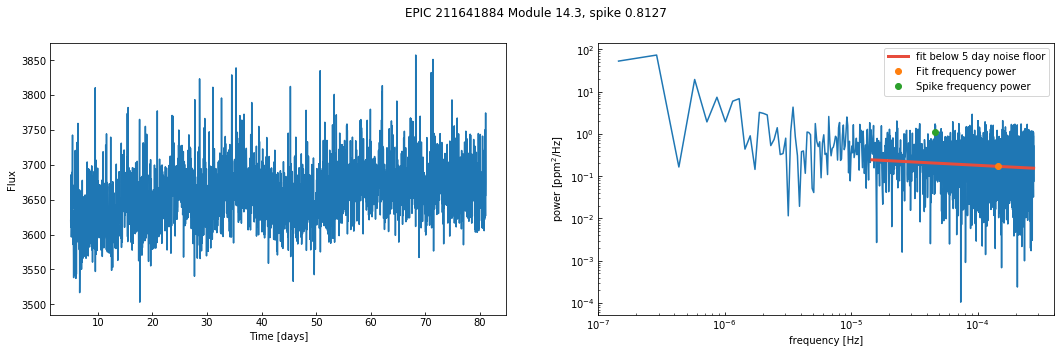

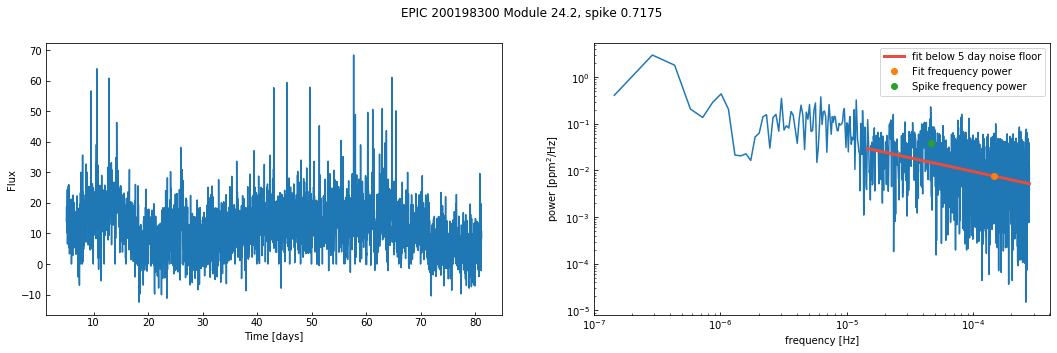

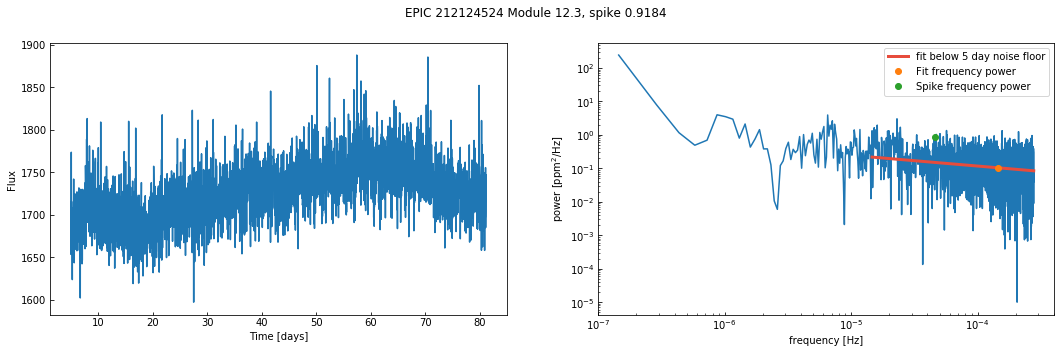

In [9]:
campaign=16
cadences = 3894#33894 for C16
time = np.arange(cadences)/48.0# time in days since start of campaign

hdf5_file = "./K2C%s_target_pixels.hdf5"%campaign
with h5py.File(hdf5_file, 'r') as f:
    for i in range(len(temp_df)):
        epic = int(np.array(temp_df['EPIC'])[i])
        mod = int(np.array(temp_df['module'])[i])
        submod = int(np.array(temp_df['submodule'])[i])
        gini = np.array(temp_df['gini'])[i]
        
        
        d = np.array(f['%s/%s/%s/%s'%(campaign,mod,submod,epic)]['data'])
        lc_hdf5 = np.nansum(np.nansum(d, axis=1), axis=1)
        # handle spurious cadences
        lc = lk.LightCurve(time, flux=lc_hdf5)
        _, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
        lc_raw = lc.flux

        # interpolate
        cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement
        interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
        # replace spurious cadence values with the interpolated values
        lc_raw[spurious_cad] = interped_vals
        
        # calculate the PSD (looking for spikes at )        
        freq_raw,power_raw = LS_PSD(time*86400,lc_raw,f=k2_freq)
        
        
        # noise floor are freqencies > X days, convert to Hz
        noise_floor_days = 5
        noise_floor_mask = freq_raw>(2*np.pi/(noise_floor_days*86400))
        m_noise, b_noise = np.polyfit(np.log10(freq_raw)[noise_floor_mask], np.log10(power_raw)[noise_floor_mask], 1)
        
        freq_six_hour = (2*np.pi/(0.5*86400)) # frequency for 4*6 hour thurster fire
        
        # lomb scargle for single frequency
        # Compute the LS based power spectrum estimates
        model = LombScargle(time*86400, lc_raw)
        power_six_hour = model.power(freq_six_hour, method="fast", normalization="psd")
        power_six_hour /= len(time)

        #freq_temp = (2*np.pi/(0.375*86400)) #0.25*1.5
        freq_temp = k2_freq[320]
        power_temp = model.power(freq_temp, method="fast", normalization="psd")
        power_temp /= len(time)
        
        #spike = np.abs(power_six_hour/power_temp)
        #np.log10(power_six_hour - 10**(np.log10(freq_six_hour)*m_noise+b_noise))-np.log10(power_raw[0])
        spike = np.log10(power_temp/(10**(np.log10(freq_six_hour)*m_noise+b_noise)))
        
        
        # plotting the lightcurves after 5 days, since there seems to be some kind of weirdness in the begining
        cutoff = time > 5
        
        fig, ax = plt.subplots(1,2, figsize=(18,5))
        ax[0].plot(time[cutoff], lc_raw[cutoff])
        ax[0].set_xlabel("Time [days]")
        ax[0].set_ylabel("Flux")
        
        
        ax[1].plot(freq_raw, power_raw)
        ax[1].plot(freq_raw[noise_floor_mask], 10**(np.log10(freq_raw[noise_floor_mask])*m_noise+b_noise), 
             label="fit below 5 day noise floor"%m_noise, linewidth=3, alpha = 1, color='#e74c3c')
        ax[1].plot(freq_six_hour, 10**(np.log10(freq_six_hour)*m_noise+b_noise), 'o', label="Fit frequency power")
        ax[1].plot(freq_temp, power_temp, 'o', label="Spike frequency power")
        
        ax[1].set_xlabel("frequency [Hz]")
        ax[1].set_ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].legend()
        fig.suptitle("EPIC %s Module %s.%s, spike %.4f"%(epic,mod,submod, spike))
        
        #fig.savefig("./submit/c%s_control/EPIC_%s.png"%(campaign,epic))
        #plt.close()

Once again, these objects look like good possible control samples.